In [1]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib as mpl

from scipy import linalg
from scipy.stats import kurtosis, mode
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI, mutual_info_score as MI
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import GaussianRandomProjection as GRP

%matplotlib inline

In [4]:
df_main = pd.read_csv("./assets/cleaned_student_data.csv")
X_student = df_main.iloc[:, :-1].astype('float')
y_student = df_main.iloc[:, -1]

In [5]:
df_main = pd.read_csv("./assets/cleaned_housing_data.csv")
X_housing = df_main.iloc[:, :-1].astype('float')
y_housing = df_main.iloc[:, -1]
re_label = dict(zip(y_housing.unique()[::-1], range(y_housing.unique().size)))  # convert 'Group x' to int
y_housing = y_housing.replace(re_label) 

In [6]:
def silhouette_analysis(X, y, range_n_clusters):
    """
    Code pulled from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    """
    df_results = pd.DataFrame(index=['clf_acc', 'nmi', 'sil_score'], columns=range_n_clusters)
    
    for n_clusters in range_n_clusters:
        print("\nFor {} clusters".format(n_clusters))
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=7308, n_jobs=-1)
        cluster_labels = clusterer.fit_predict(X)

        acc = accuracy_score(y, cluster_labels)
        nmi = NMI(y, cluster_labels)
        print("K-Means classification accuracy: {}".format(acc))
        print("K-Means NMI: {}".format(nmi))
        
        df_results.loc['clf_acc', n_clusters] = acc
        df_results.loc['nmi', n_clusters] = nmi
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
        df_results.loc['sil_score', n_clusters] = silhouette_avg
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
        print("~~~~\n")
        
    return df_results

        
def plot_gmm(X, Y_, means, covariances, index, title):
    
    color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
    f = plt.figure(figsize=(10,8))
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
    plt.scatter(means[:, 0], means[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(means):
        plt.scatter( c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    plt.xlabel("1st feature")
    plt.ylabel("2nd feature")

    plt.title(title)

    
def em_analysis(X, y, range_n_comps):
    df_results = pd.DataFrame(index=['clf_acc', 'nmi'], columns=range_n_comps)
    
    for n_comps in range_n_comps:
        gmm = GMM(n_comps, random_state=7308)
        gmm.fit(X)
        cluster_labels = gmm.predict(X)

        acc = accuracy_score(y, cluster_labels)
        nmi = NMI(y, cluster_labels)
        print("EM classification accuracy: {}".format(acc))
        print("EM NMI: {}".format(nmi))
        
        df_results.loc['clf_acc', n_comps] = acc
        df_results.loc['nmi', n_comps] = nmi
        
        plot_gmm(X, cluster_labels, 
                 gmm.means_, gmm.covariances_, 0,
                 "EM analysis on sample data with n_components: {}".format(n_comps))
        plt.show()
    
    return df_results

In [7]:
scaler = StandardScaler()
X_student_std = scaler.fit_transform(X_student)
X_housing_std = scaler.fit_transform(X_housing)


For 2 clusters
K-Means classification accuracy: 0.548
K-Means NMI: 0.006248544621491836
For n_clusters = 2 The average silhouette_score is : 0.11681044526331899


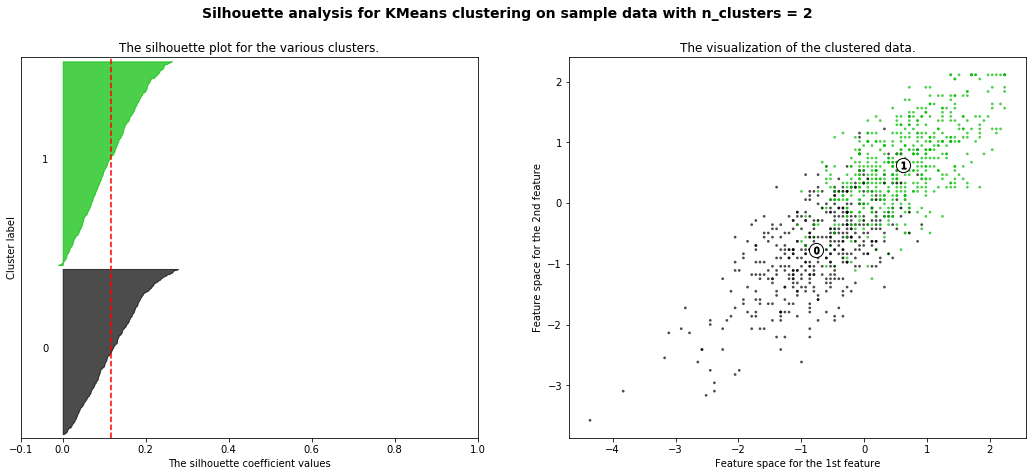

~~~~


For 3 clusters
K-Means classification accuracy: 0.293
K-Means NMI: 0.00010313825014566038
For n_clusters = 3 The average silhouette_score is : 0.1270878577410537


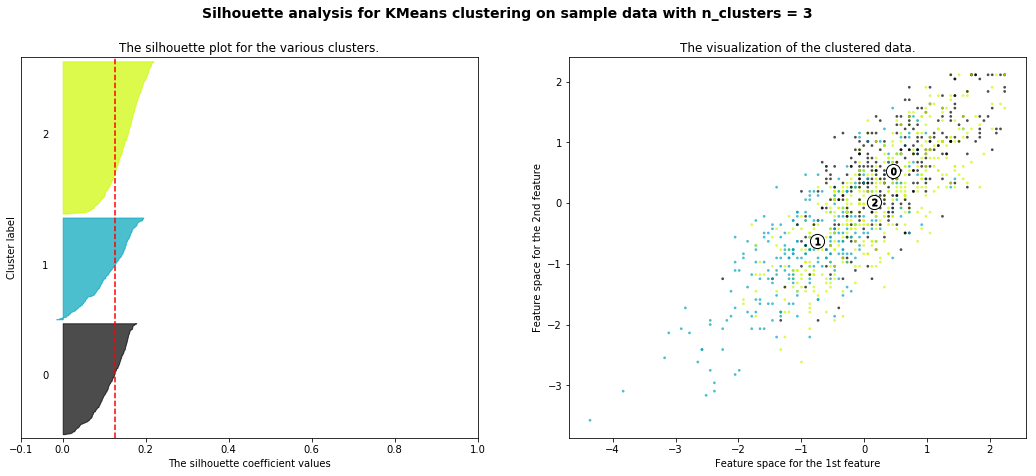

~~~~


For 4 clusters
K-Means classification accuracy: 0.226
K-Means NMI: 0.008648814993648512
For n_clusters = 4 The average silhouette_score is : 0.09947444212811506


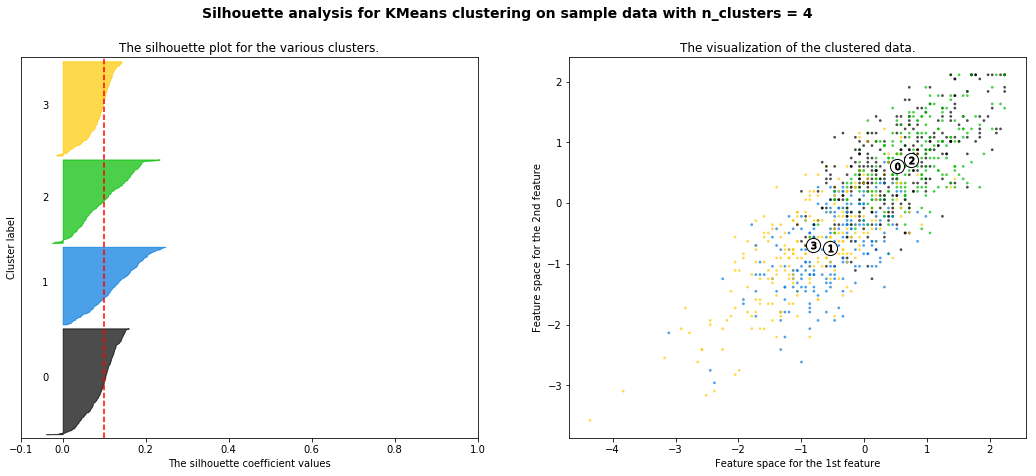

~~~~


For 5 clusters
K-Means classification accuracy: 0.229
K-Means NMI: 0.00850516602721859
For n_clusters = 5 The average silhouette_score is : 0.11027750516125946


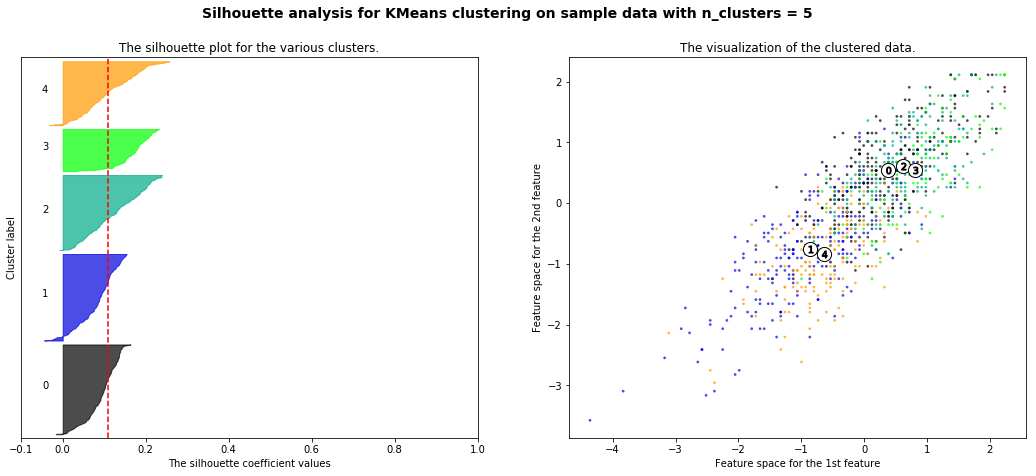

~~~~


For 6 clusters
K-Means classification accuracy: 0.199
K-Means NMI: 0.005072392557093822
For n_clusters = 6 The average silhouette_score is : 0.15559386713489382


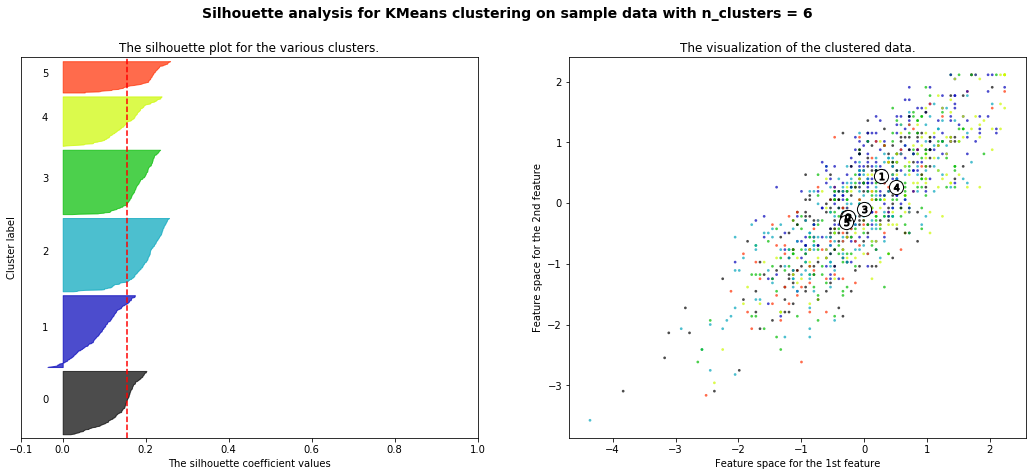

~~~~


For 7 clusters
K-Means classification accuracy: 0.153
K-Means NMI: 0.004223620595620461
For n_clusters = 7 The average silhouette_score is : 0.16114936676336458


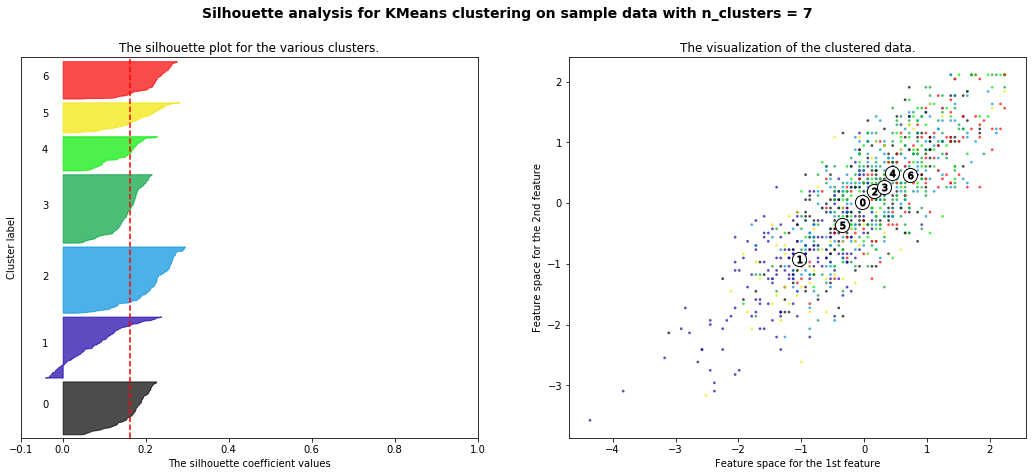

~~~~


For 8 clusters
K-Means classification accuracy: 0.104
K-Means NMI: 0.003448907363202346
For n_clusters = 8 The average silhouette_score is : 0.16616689629802703


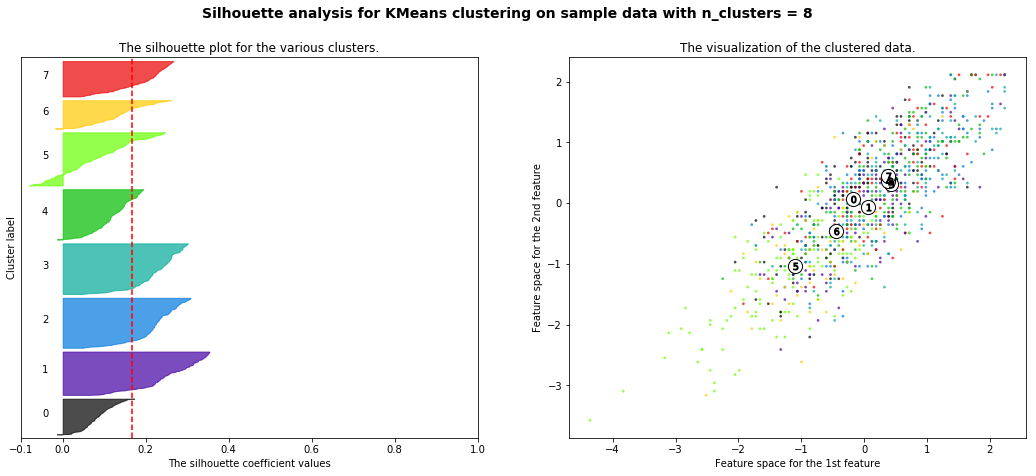

~~~~



In [8]:
km_student_r = silhouette_analysis(X_student_std, y_student, range(2,9))

EM classification accuracy: 0.505
EM NMI: 0.0003404071142456021


/home/mtong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in double_scalars


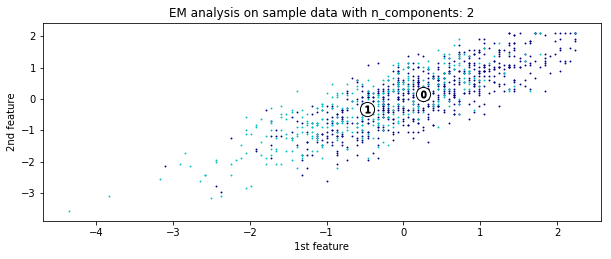

EM classification accuracy: 0.322
EM NMI: 0.00011816972780934907


/home/mtong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in double_scalars


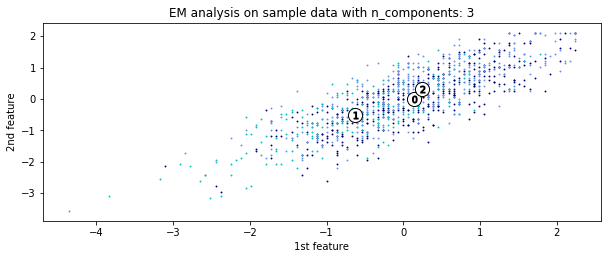

EM classification accuracy: 0.276
EM NMI: 0.000455322594042475


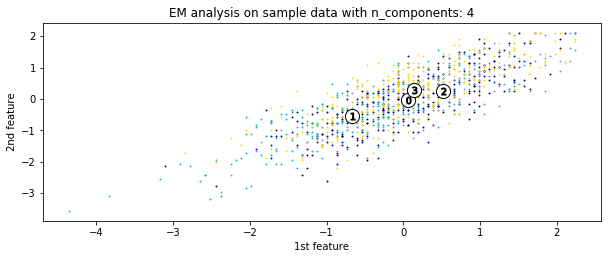

EM classification accuracy: 0.241
EM NMI: 0.00012063970852905931


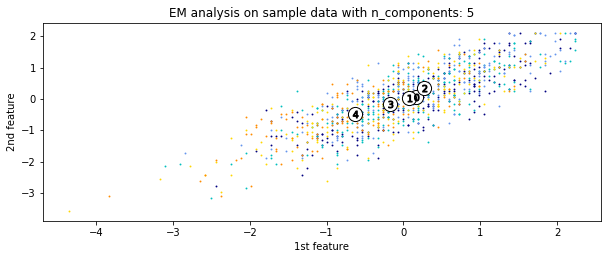

EM classification accuracy: 0.199
EM NMI: 0.00020048142336916204


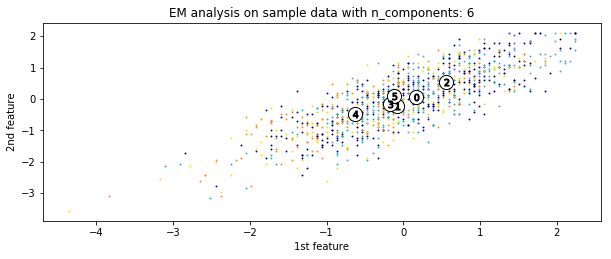

EM classification accuracy: 0.181
EM NMI: 0.0005357143238235748


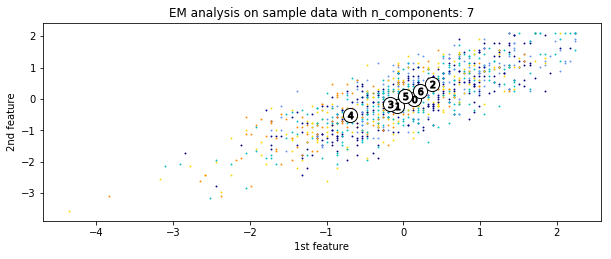

EM classification accuracy: 0.099
EM NMI: 0.004531400082973071


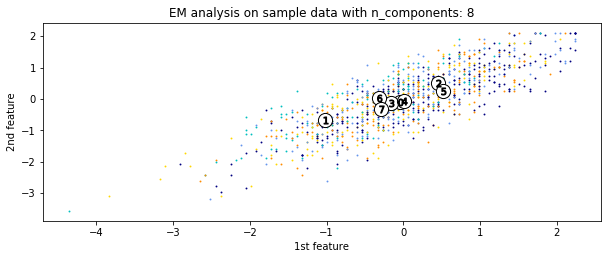

In [9]:
em_student_r = em_analysis(X_student_std, y_student, range(2, 9))

In [ ]:
km_housing_r = silhouette_analysis(X_housing_std, y_housing, range(2,9))

EM classification accuracy: 0.33062946697666407
EM NMI: 7.65401871919163e-05


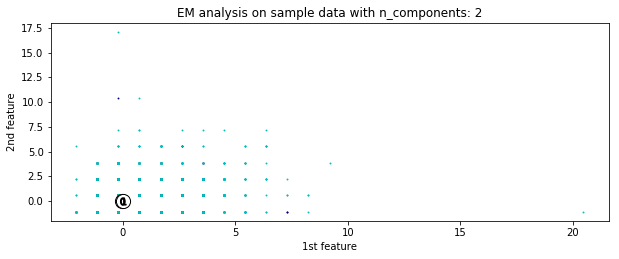

EM classification accuracy: 0.3275983811246017
EM NMI: 0.0001323010523824211


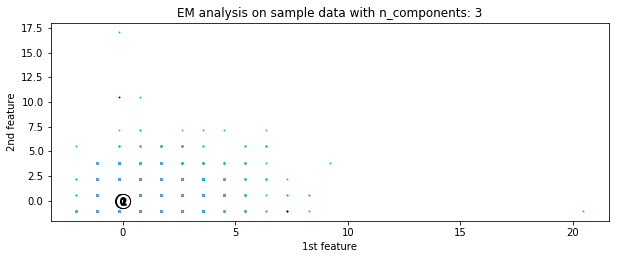

EM classification accuracy: 0.2907086885387066
EM NMI: 0.00018918765285781195


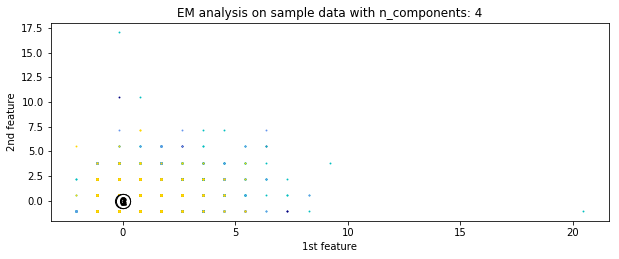

EM classification accuracy: 0.25311289072591064
EM NMI: 0.00021196395434818115


/home/mtong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in double_scalars


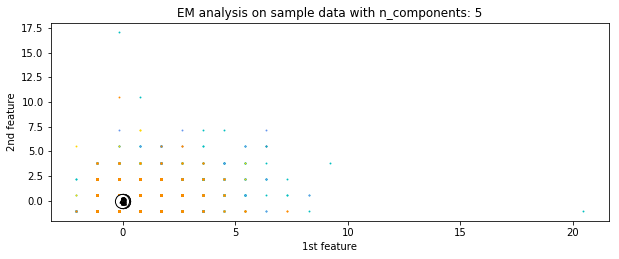

EM classification accuracy: 0.20325497287522604
EM NMI: 0.0002116113897108732


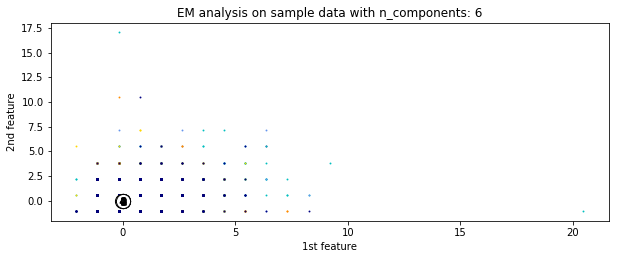

EM classification accuracy: 0.17773185223456472
EM NMI: 0.00025225978427021725


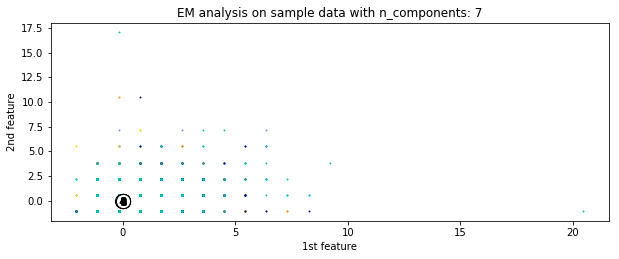

EM classification accuracy: 0.09549642641866873
EM NMI: 0.0002845660282848658


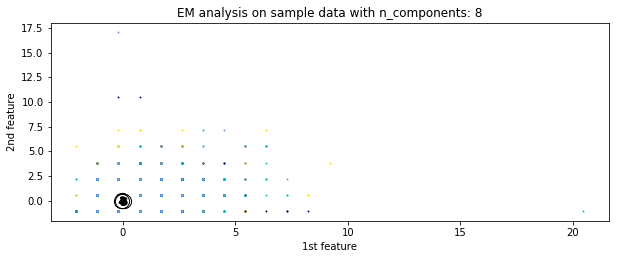

In [92]:
em_housing_r = em_analysis(X_housing_std, y_housing, range(2, 9))

In [96]:
km_student_r.to_csv("./student_cluster_baseline_km.csv")
km_housing_r.to_csv("./housing_cluster_baseline_km.csv")
em_student_r.to_csv("./student_cluster_baseline_em.csv")
em_housing_r.to_csv("./housing_cluster_baseline_em.csv")

In [53]:
gmm = GMM(2, random_state=7308)
gmm.fit(X_housing_std)
cluster_labels = gmm.predict(X_housing_std)

In [51]:
kurtosis(gmm.predict_proba(X_housing_std)[:, 0])

2.136449661354856

In [60]:
pca = PCA(3, random_state=7308)
pca.fit(X_student_std)
pca.components_

array([[-0.46449385, -0.47414243, -0.48800172,  0.07301088,  0.0570186 ,
         0.01646834, -0.02544897, -0.11424942, -0.05266661, -0.06600243,
         0.12222023, -0.05412448, -0.01808773,  0.03907939,  0.27299311,
        -0.27299311, -0.2478236 ,  0.2478236 ],
       [-0.08538603,  0.01744314,  0.04598496,  0.03126931,  0.00773003,
         0.03360468, -0.06382311,  0.00134143,  0.00991634,  0.04494276,
        -0.08438464,  0.01206875, -0.03823962,  0.0731119 ,  0.46477073,
        -0.46477073,  0.51760626, -0.51760626],
       [-0.15152018, -0.20062567, -0.19370171,  0.12415751,  0.22534865,
         0.11600488, -0.37066426, -0.04275862, -0.04273256, -0.10299984,
         0.19579006, -0.23738731, -0.17443435,  0.26647802, -0.37788947,
         0.37788947,  0.30515225, -0.30515225]])